# Initial Income and Trip Analysis

This notebook explores the income-related questions that we wanted to first answer.  Essentially, we are looking for high-level patterns between user income, trip fare, route choice, and frequency of use.

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressMessages(library(lubridate))
library(RSQLCipher)

In [2]:
Sys.setenv("SQL_KEY"=Sys.getenv("HOT_KEY"))
options(repr.plot.width=10, repr.plot.height=6)

In [3]:
db_path = "../../../data/hot.db"

# import tables
trips = load_table(db_path, "trips_linked", c(tag_id="c", acct="c", 
                                              plate="c", id="c", zip="c"))
acs = load_table(db_path, "acs")
acct_stats = load_table(db_path, "acct_stats", c(id="c"))

In [4]:
noncomm_accts = select(acct_stats, id, commercial) %>% filter(commercial==0)

In [5]:
trips.2pct = load_table(db_path, "trips_2pct") %>% execute

Warning message:
“13 parsing failures.
  row col expected  actual         file
 7643 zip a double V3W7X4  literal data
45036 zip a double v7b1k7  literal data
58788 zip a double V6H 3W6 literal data
72041 zip a double V3W7X4  literal data
84177 zip a double V3W7X4  literal data
..... ... ........ ....... ............
See problems(...) for more details.
”

## What is the distribution of income in the northern part of the metropolitan area, and among all HOT lane users?

The average median household income in the northern metro is around \\$91,000.  Income shares of each group are summarized and plotted below

In [7]:
acs.d = filter(acs, county_name == "King" | county_name == "Snohomish") %>% execute

weighted.mean(acs.d$med_inc, acs.d$population, na.rm=T)

[1] 90712.98

In [8]:
mean(trips.2pct$med_inc, na.rm=T)

[1] 100411.3

In [9]:
inc_shares_metro = acs.d %>% 
    summarize_at(vars(starts_with("inc_")), ~ weighted.mean(., w=population, na.rm=T)) %>%
    gather(inc_group, pct)
inc_shares_metro

inc_group,pct
<chr>,<dbl>
inc_000_035k,0.19203068
inc_035_050k,0.09963958
inc_050_075k,0.15855165
inc_075_100k,0.13370418
inc_100_125k,0.11270924
inc_125_150k,0.08086009
inc_150_200k,0.10131787
inc_200_infk,0.12118669


In [10]:
inc_shares_hot = trips.2pct %>%
    summarize_at(vars(starts_with("inc_")), mean, na.rm=T) %>%
    gather(inc_group, pct)
inc_shares_hot

inc_group,pct
<chr>,<dbl>
inc_000_035k,0.15238550
inc_035_050k,0.08561494
inc_050_075k,0.15000838
inc_075_100k,0.13667359
inc_100_125k,0.12472077
inc_125_150k,0.09066657
inc_150_200k,0.12109477
inc_200_infk,0.13883549


In [11]:
inc_shares = inc_shares_metro %>%
    transmute(inc_group = inc_group,
              pct_metro = pct,
              pct_hot = inc_shares_hot$pct)

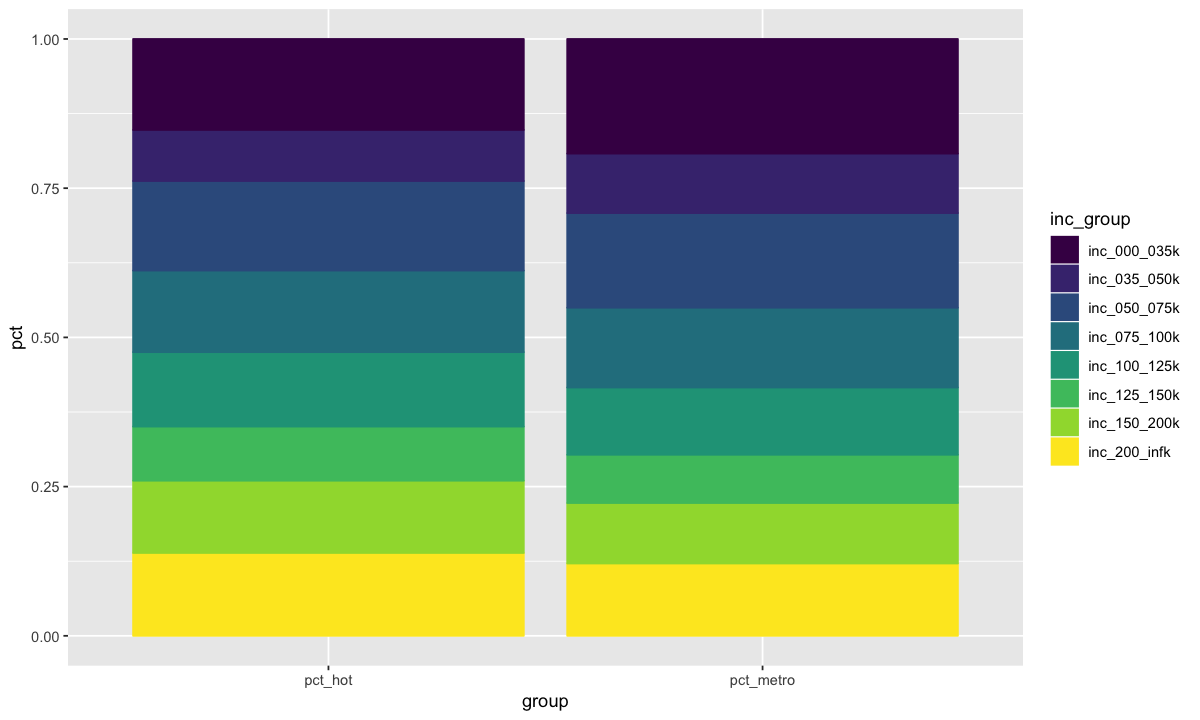

In [12]:
inc_shares %>%
    gather(group, pct, -inc_group) %>%
ggplot(aes(x=group, y=pct, group=inc_group, color=inc_group, fill=inc_group)) +
    geom_col() + 
    #geom_line() +
    scale_fill_viridis_d() +
    scale_color_viridis_d()

## What is the distribution of income across toll levels?

We plot (our best estimate of) the fraction of total users in each income category, as the toll varies. We observe small but significant trends in these user shares across the toll range.

What is surprising is the consistency in income distribution across tolls.  What is more surprising is the trends over toll value, which are small but consistent, and in which are in the exact opposite direction one might naively expect. Poor drivers make up an increasing share of trips as the toll increases, while rich drivers make up a decreasing share of trips.

In [230]:
# The next 3 cells GENERATE the data. The cell after READS the generated data. 
# Don't run this cell unless you want to regenerate the data.
# costly!
inc_tolls = semi_join(trips, noncomm_accts, by="id") %>%
        select(toll, fips) %>%
        left_join(select(acs, fips_code, contains("inc")), by=c("fips"="fips_code")) %>%
    group_by(toll) %>%
    summarize_at(vars(contains("inc")), mean, na.rm=T) %>%
    execute

In [108]:
# costly!
inc_tolls_ct = semi_join(trips, noncomm_accts, by="id") %>%
        select(toll, fips) %>%
        left_join(select(acs, fips_code, contains("inc")), by=c("fips"="fips_code")) %>%
    group_by(toll) %>%
    summarize(count=n()) %>%
    execute

In [113]:
inc_tolls$count = inc_tolls_ct$count
write_csv(inc_tolls, "../../data/output/income_by_toll.csv")

In [238]:
inc_tolls = read_csv("../../data/output/income_by_toll.csv")

Parsed with column specification:
cols(
  toll = col_double(),
  inc_000_035k = col_double(),
  inc_035_050k = col_double(),
  inc_050_075k = col_double(),
  inc_075_100k = col_double(),
  inc_100_125k = col_double(),
  inc_125_150k = col_double(),
  inc_150_200k = col_double(),
  inc_200_infk = col_double(),
  med_inc = col_double(),
  count = col_double()
)


In [13]:
# We can also generate the data from a 2% sample of the trip file
inc_tolls = trips.2pct %>%
    filter(toll*4 == as.integer(toll*4), commercial == 0) %>%
    group_by(toll) %>%
    summarize_at(vars(contains("inc")), mean, na.rm=T) %>%
    left_join(
        trips.2pct %>% 
        filter(toll*4 == as.integer(toll*4), commercial == 0) %>%
        group_by(toll) %>%
        summarize(count=n()),
        by="toll"
    )

In [15]:
inc_tolls

toll,inc_000_035k,inc_035_050k,inc_050_075k,inc_075_100k,inc_100_125k,inc_125_150k,inc_150_200k,inc_200_infk,med_inc,count
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0.00,0.1458817,0.08669737,0.1509580,0.1388710,0.1281258,0.09167674,0.1230981,0.13469125,100131.28,39230
0.75,0.1513866,0.08511442,0.1469807,0.1341413,0.1244296,0.08983505,0.1214641,0.14664818,102214.24,62396
1.00,0.1461054,0.08565886,0.1501337,0.1372480,0.1248180,0.09303139,0.1252221,0.13778268,100961.95,3034
1.25,0.1464163,0.08570124,0.1533468,0.1399630,0.1278207,0.09165655,0.1242814,0.13081399,99421.62,2355
1.50,0.1489136,0.08588400,0.1537067,0.1400509,0.1275923,0.09047044,0.1200425,0.13333953,99301.67,2772
1.75,0.1494997,0.08464741,0.1515708,0.1408612,0.1252015,0.09188762,0.1229381,0.13339362,99889.62,2704
2.00,0.1440535,0.08486282,0.1507994,0.1369809,0.1265100,0.09497766,0.1245111,0.13730452,101831.37,2265
2.25,0.1427652,0.08198925,0.1516675,0.1414150,0.1289498,0.09481585,0.1229915,0.13540583,101367.14,1511
2.50,0.1474408,0.08423180,0.1447230,0.1379561,0.1265377,0.09188091,0.1220658,0.14516379,102916.02,1116


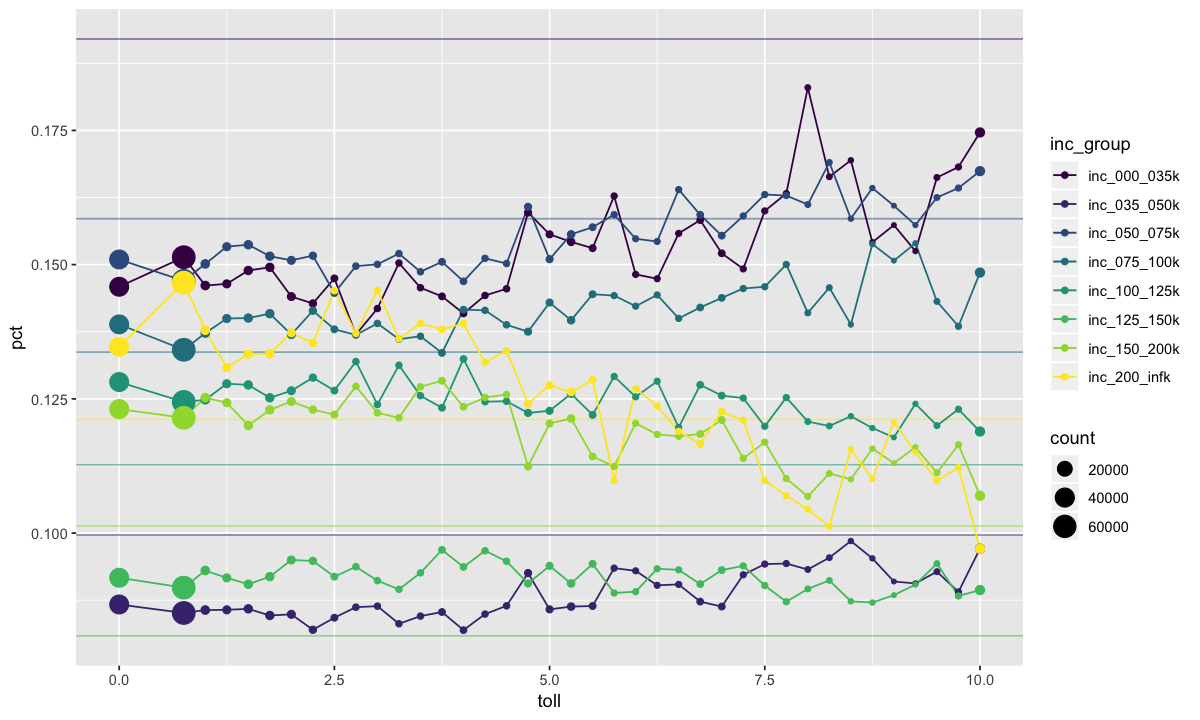

In [18]:
inc_tolls %>%
    #filter(toll >= 1) %>%
    #mutate_at(vars(starts_with("inc_")), ~ . * count) %>%
    select(-med_inc) %>%
    gather(inc_group, pct, -toll, -count) %>%
ggplot(aes(toll, pct, color=inc_group, group=inc_group)) +
    geom_hline(aes(yintercept=pct_metro, color=inc_group), data=inc_shares, alpha=0.5) +
    geom_line() + 
    geom_point(aes(size=count)) +
    scale_color_viridis_d()

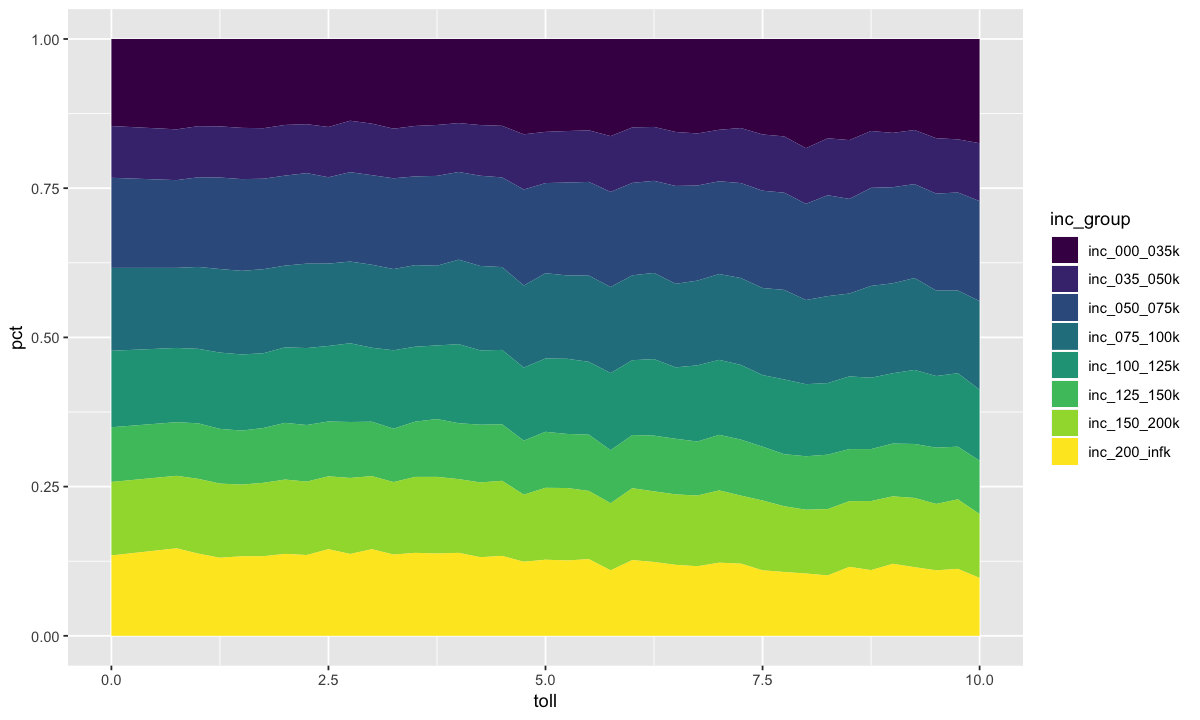

In [19]:
inc_tolls %>%
    filter(toll*4 == as.integer(toll*4)) %>%
    #mutate_at(vars(starts_with("inc_")), ~ . * count) %>%
    select(-med_inc, -count) %>%
    gather(inc_group, pct, -toll) %>%
    drop_na %>%
ggplot(aes(toll, pct, fill=inc_group)) + 
    geom_area() +
    scale_fill_viridis_d()

We can fit a linear model with a toll/income interaction to estimate the average slope of the lines in the figure above, and the estimated change from the left-hand to right-hand side of the figure (as the toll goes from \\$0.75 to \\$10.00).

In [20]:
m.inc = inc_tolls %>%
    filter(toll*4 == as.integer(toll*4)) %>%
    select(-med_inc) %>%
    gather(inc_group, pct, -toll) %>%
    mutate(min_inc = parse_number(str_match(inc_group, "inc_([0-9]+)_.+k")[,2])) %>%
lm(pct ~ toll + toll:min_inc + as_factor(min_inc), data=.)

coef.toll = coef(m.inc)["toll"]
coef.inter = coef(m.inc)["toll:min_inc"]
inc.levels = parse_number(m.inc$xlevels[[1]])
tibble(income=inc.levels*1000, slope=9.25*100*(coef.toll+coef.inter*inc.levels))

income,slope
<dbl>,<dbl>
0,2.6122940
35000,1.6171344
50000,1.1906374
75000,0.4798091
100000,-0.2310192
125000,-0.9418475
150000,-1.6526758
200000,-3.0743324


## What is the distribution of income across user use frequencies?

First, we have to create frequency categories.  An exploratory plot suggests the following categories:
- single-use user (1 trip in 2018)
- monthly user (2-40 trips)
- weekly user (41-120 trips)
- regular user (121-400 trips)
- daily user (401-600 trips)
- high-frequency user (601+ trips)

In [289]:
user_freq = select(trips, id, fips)  %>% 
    filter(!is.na(fips)) %>%
    group_by(id) %>%
    summarize(trips=n()) %>%
    head(1000) %>%
    execute

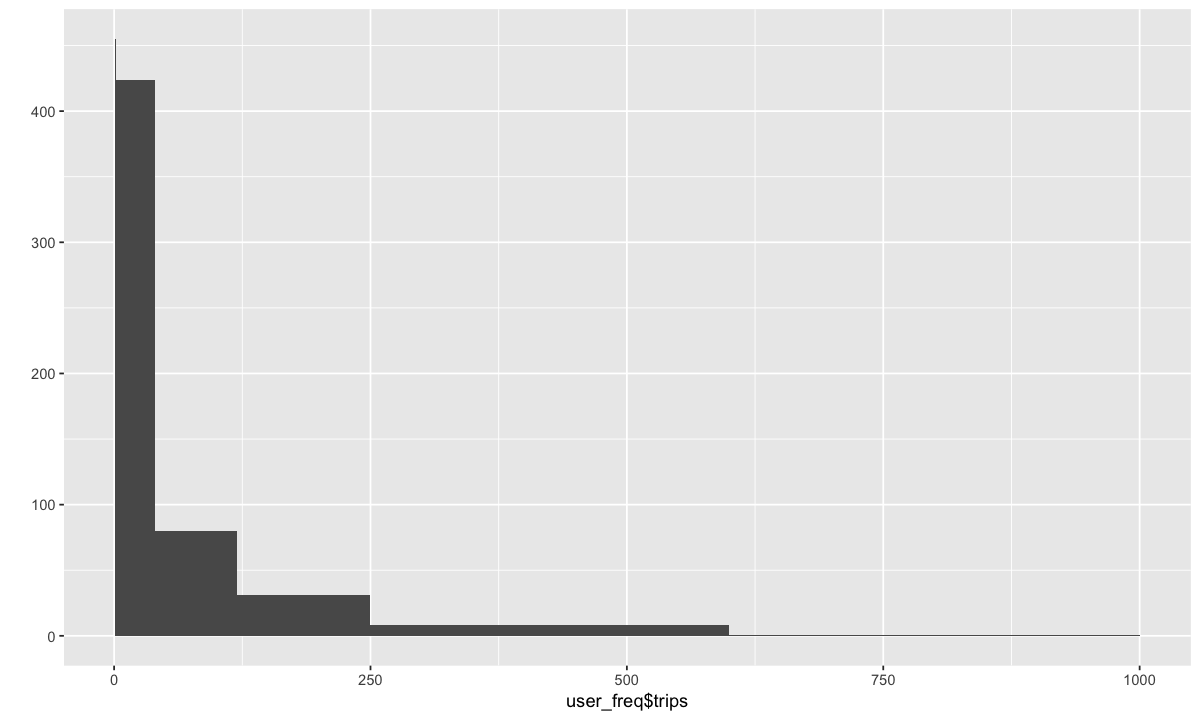

In [290]:
qplot(user_freq$trips, breaks=c(1,2,40,120,250,600,1000))

In [211]:
# AS ABOVE, next 3 cells generate and save the data.
# Don't run unless you want to regenerate the data

user_freq = select(trips, id, fips)  %>% 
    filter(!is.na(fips)) %>%
    group_by(id) %>%
    summarize(freq = case_when(
        n() == 1 ~ "1_single",
        n() <= 40 ~ "2_monthly",
        n() <= 120 ~ "3_weekly",
        n() <= 250 ~ "4_regular",
        n() <= 600 ~ "5_daily",
        T ~ "6_high"
    ))

In [183]:
inc_freq_raw = inner_join(select(trips, id, fips),
                     user_freq, by="id") %>%
    left_join(select(acs, fips_code, contains("inc")),
              by=c("fips"="fips_code")) %>%
    group_by(freq)

inc_freq = inc_freq_raw %>%
    summarize_at(vars(contains("inc")), mean, na.rm=T) %>%
    execute(col_types="cddddddddd")

In [190]:
inc_freq_ct = user_freq %>% 
    group_by(freq) %>% 
    summarize(count=n()) %>% 
    execute(col_types="ci")
inc_freq$count = inc_freq_ct$count

In [191]:
write_csv(inc_freq, "../../data/output/income_by_freq.csv")

We can plot the share of total trips in each frequency category by income.  The trends are not as clear as with the toll price, but as the mean median income plot demonstrates, richer users do tend to use the system more frequently.  The one exception is the high-frequency users, which are a small fraction of the total.

In [292]:
inc_freq = read_csv("../../data/output/income_by_freq.csv", col_types="cdddddddddi")
inc_freq

freq,inc_000_035k,inc_035_050k,inc_050_075k,inc_075_100k,inc_100_125k,inc_125_150k,inc_150_200k,inc_200_infk,med_inc,count
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1_single,0.1833019,0.09571181,0.1617140,0.1374164,0.1161829,0.08219708,0.1023289,0.1211469,92130.44,2427
2_monthly,0.1617308,0.08823584,0.1509379,0.1357450,0.1199232,0.08745752,0.1148833,0.1410863,99470.61,33947
3_weekly,0.1517806,0.08768839,0.1512263,0.1375990,0.1233584,0.08991649,0.1195461,0.1388848,100262.44,33124
4_regular,0.1460384,0.08490045,0.1479069,0.1372946,0.1279722,0.09283863,0.1229342,0.1401146,101840.92,35222
5_daily,0.1376964,0.08267228,0.1469118,0.1369648,0.1291339,0.09603011,0.1296114,0.1409793,103585.97,27747
6_high,0.1701429,0.09229243,0.1602776,0.1212426,0.1175371,0.08799929,0.1201745,0.1303336,97427.26,1899


In [21]:
# We can also generate the data from a 2% sample of the trip file
inc_freq = trips.2pct %>%
    filter(commercial == 0) %>%
    group_by(freq) %>%
    summarize_at(vars(contains("inc")), mean, na.rm=T) %>%
    left_join(
        trips.2pct %>% 
        filter(commercial == 0) %>%
        group_by(freq) %>%
        summarize(count=n()),
        by="freq"
    )

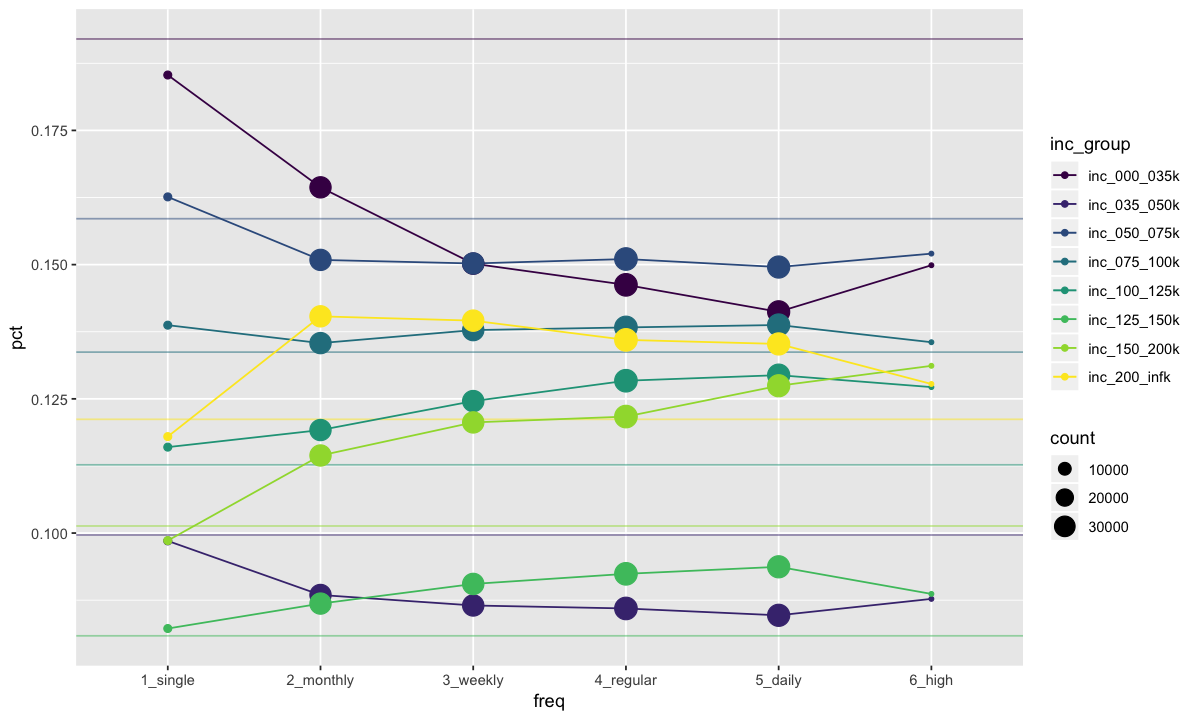

In [22]:
inc_freq %>%
    select(-med_inc) %>%
    #mutate_at(vars(starts_with("inc_")), ~ . * count) %>%
    gather(inc_group, pct, -freq, -count) %>%
    drop_na %>%
ggplot(aes(freq, pct, color=inc_group, group=inc_group)) +
    geom_hline(aes(yintercept=pct_metro, color=inc_group), data=inc_shares, alpha=0.5) +
    geom_line() + 
    geom_point(aes(size=count)) +
    scale_color_viridis_d()

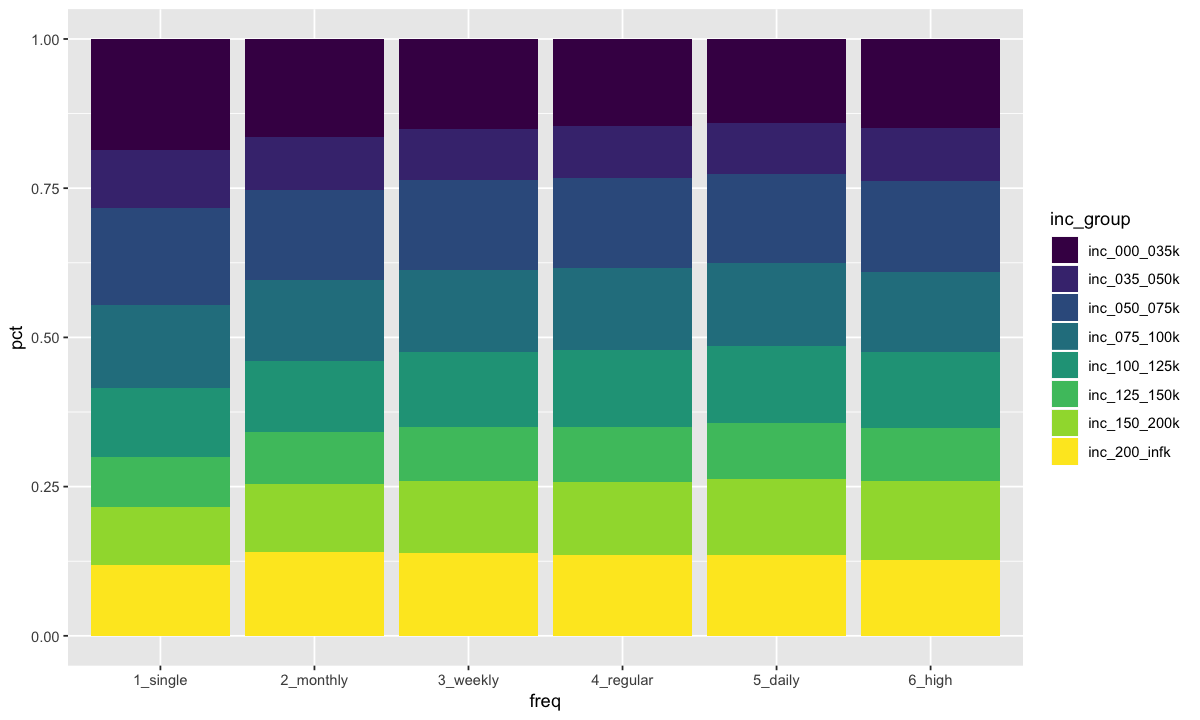

In [23]:
inc_freq %>%
    #mutate_at(vars(starts_with("inc_")), ~ . * count) %>%
    select(-med_inc, -count) %>%
    gather(inc_group, pct, -freq) %>%
ggplot(aes(freq, pct, fill=inc_group)) + 
    geom_col() +
    scale_fill_viridis_d()

## How does income vary across toll and use frequency?

We can also plot the income share and toll graphs faceted by frequency.  These allow us to see whether the above trends (wealthier users are less common at higher tolls, while poorer users are more common) hold across user frequency groups, or whether they vary.

We notice that trends are relatively consistent, but weaker for single-trip and high-frequency users.

In [518]:
inc_toll_freq = trips.2pct %>%
    filter(commercial == 0, toll*4 == as.integer(toll*4)) %>%
    group_by(freq, toll) %>%
    summarize_at(vars(contains("inc")), mean, na.rm=T) %>%
    left_join(
        trips.1pct %>% 
        filter(commercial == 0) %>%
        group_by(freq, toll) %>%
        summarize(count=n()),
        by=c("freq", "toll")
    )

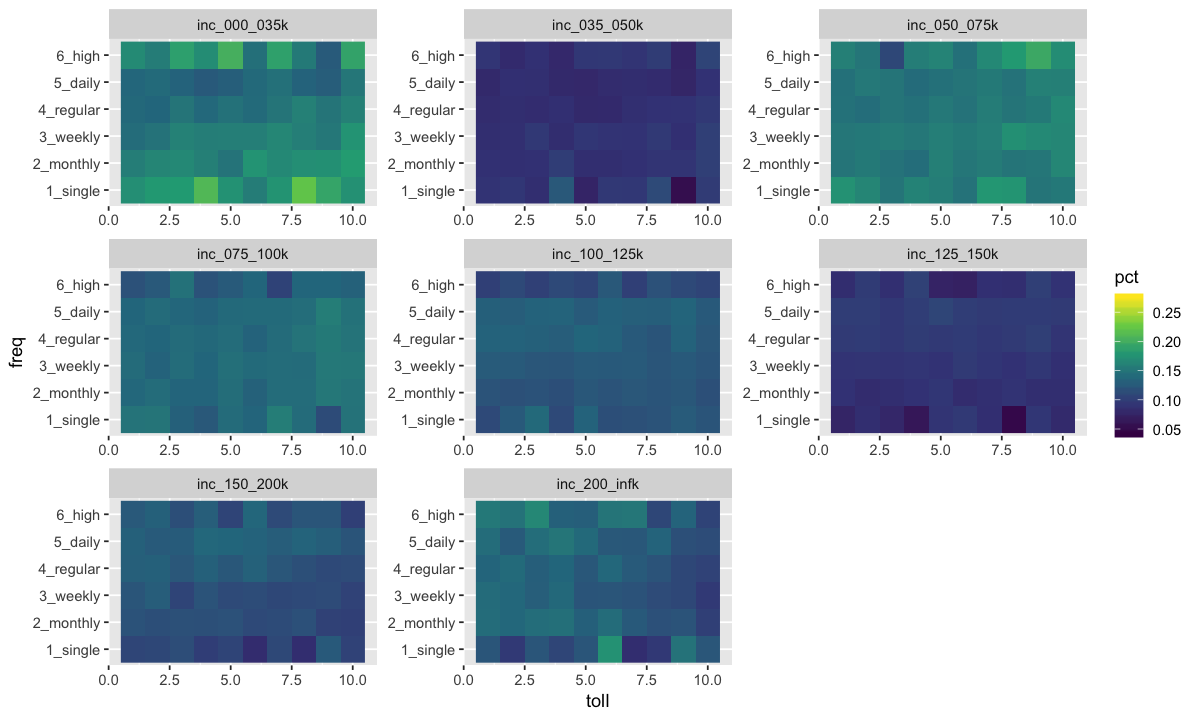

In [547]:
inc_toll_freq %>%
    filter(toll >= 1) %>%
    mutate(toll = ceiling(toll)) %>%
    select(-med_inc, -count) %>%
    gather(inc_group, pct, -toll, -freq) %>%
ggplot(aes(x=toll, y=freq, fill=pct)) +
    facet_wrap("inc_group") +
    geom_raster()

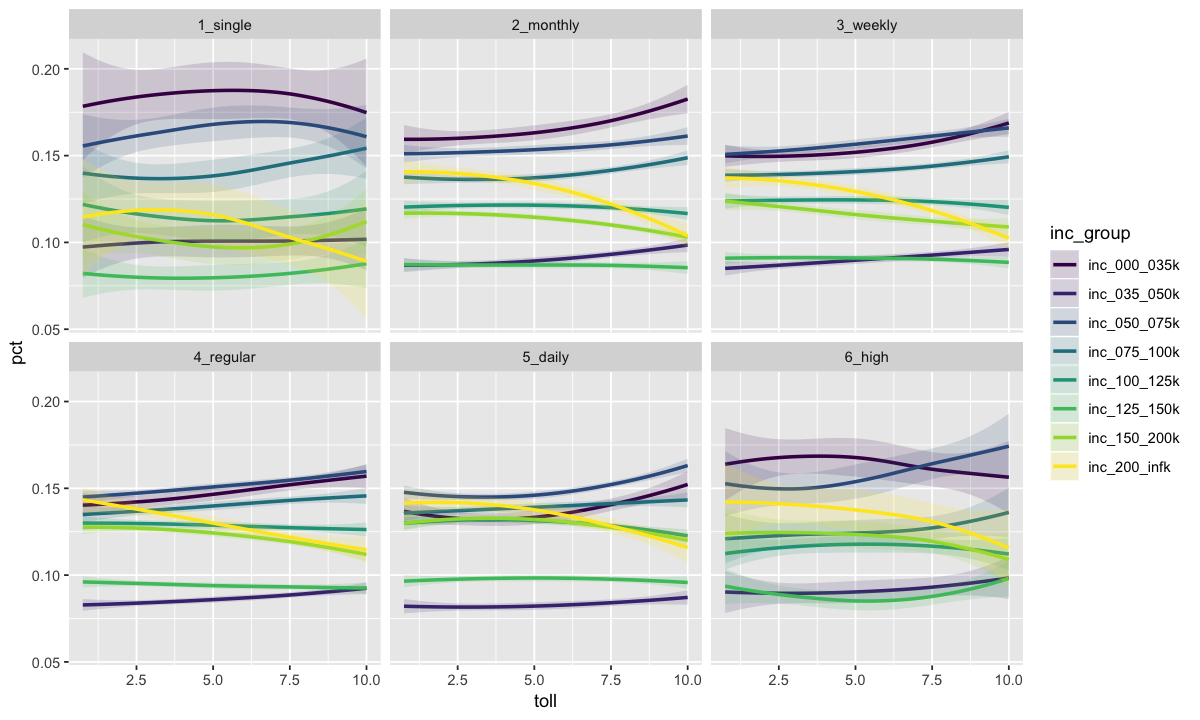

In [677]:
inc_toll_freq %>%
    select(-med_inc) %>%
    gather(inc_group, pct, -toll, -freq, -count) %>%
    drop_na %>%
ggplot(aes(toll, pct, color=inc_group, fill=inc_group, group=inc_group)) +
    #facet_wrap("freq", scales="free") +
    facet_wrap("freq") +
    geom_smooth(method="loess", span=2, alpha=0.15) +
    #geom_point(aes(size=count)) +
    scale_color_viridis_d() + 
    scale_fill_viridis_d()

## How do peak users differ from non-peak users?

Making income-toll and income-frequency plots, faceting by direction and peak, reveal few differences between peak and nonpeak users.

In [690]:
peak_data = trips.2pct %>%
    mutate(entry_time = as_datetime(entry_time),
           exit_time = as_datetime(exit_time),
           hour = hour(entry_time),
           direction = if_else(entry_plaza <= 12, "NB", "SB"),
           am_peak = hour >= 5 & hour < 9,
           pm_peak = hour >= 15 & hour < 19,
           peak = if_else(direction == "SB", am_peak, pm_peak)) %>%
    select(-def_id, -entry_plaza, -exit_plaza, -tag_id, 
           -plate_state, -id, -zip, -fips, -population)
head(peak_data)

trip_id,toll,entry_time,exit_time,is_hov,total_trips,freq,commercial,inc_000_035k,inc_035_050k,⋯,inc_150_200k,inc_200_infk,med_inc,race_nonhisp_asian,race_nonhisp_white,hour,direction,am_peak,pm_peak,peak
<dbl>,<dbl>,<dttm>,<dttm>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<lgl>,<lgl>,<lgl>
104023692,0.75,2018-01-02 07:44:27,2018-01-02 07:50:40,0,288,5_daily,0,0.08212560,0.06763285,⋯,0.15297907,0.223832528,120268,0.3818112,0.3779739,7,NB,TRUE,FALSE,FALSE
104023792,0.75,2018-01-02 08:15:05,2018-01-02 08:20:14,0,123,4_regular,0,0.02634881,0.14930991,⋯,0.17314931,0.087829360,106008,0.1777552,0.6830879,8,NB,TRUE,FALSE,FALSE
104024125,0.75,2018-01-02 08:22:47,2018-01-02 08:31:10,0,119,3_weekly,0,0.24461671,0.22997416,⋯,0.01894918,0.008613264,53539,0.1480000,0.4923636,8,SB,TRUE,FALSE,TRUE
104024166,2.50,2018-01-02 08:13:51,2018-01-02 08:26:33,0,14,2_monthly,0,0.22304833,0.17100372,⋯,0.07434944,0.000000000,62580,0.1886999,0.6472847,8,SB,TRUE,FALSE,TRUE
104024189,0.75,2018-01-02 08:16:05,2018-01-02 08:24:12,0,108,3_weekly,0,0.14303329,0.05548705,⋯,0.13810111,0.150431566,90840,0.3485968,0.5795175,8,SB,TRUE,FALSE,TRUE
104024306,0.75,2018-01-02 14:54:42,2018-01-02 14:57:09,0,184,4_regular,0,0.31663113,0.05543710,⋯,0.17803838,0.039445629,63750,0.1187186,0.7022613,14,NB,FALSE,FALSE,FALSE


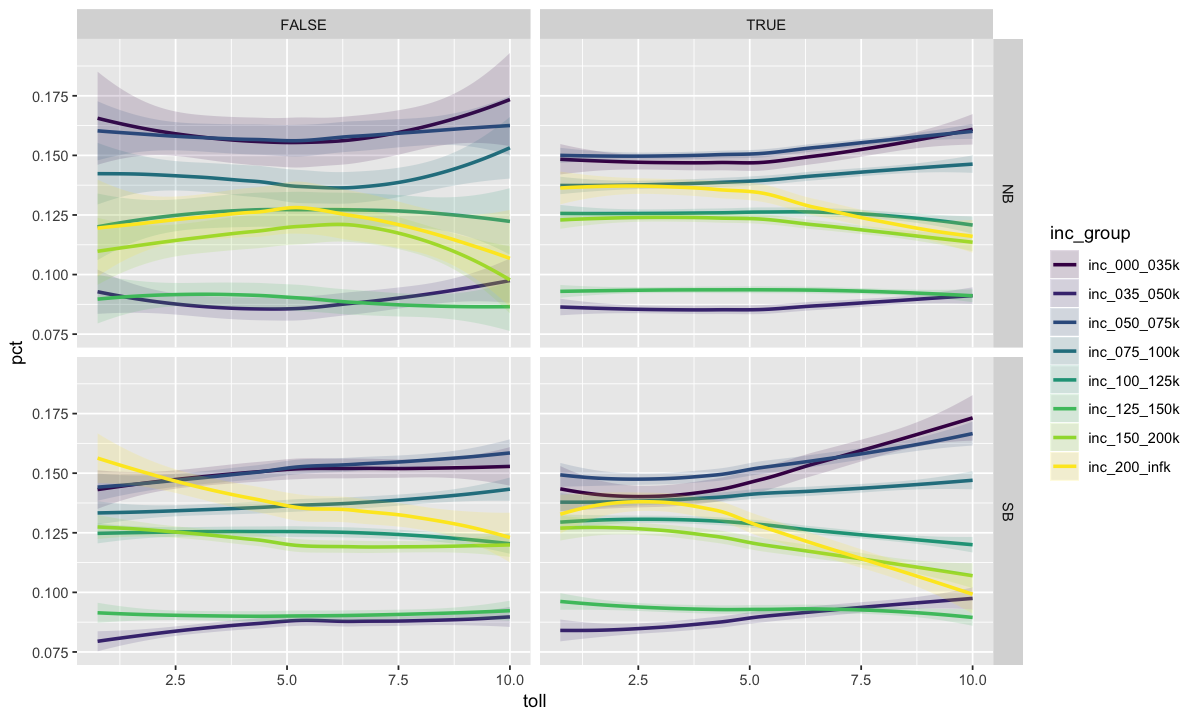

In [703]:
peak_data %>%
    filter(commercial == 0, toll*4 == as.integer(toll*4)) %>%
    group_by(peak, direction, toll) %>%
    summarize_at(vars(contains("inc")), mean, na.rm=T) %>%
    select(-med_inc) %>%
    gather(inc_group, pct, -toll, -peak, -direction) %>%
    drop_na %>%
ggplot(aes(toll, pct, color=inc_group, fill=inc_group, group=inc_group)) +
    facet_grid(direction ~ peak) +
    geom_smooth(method="loess", span=1, alpha=0.15) +
    scale_color_viridis_d() + 
    scale_fill_viridis_d()

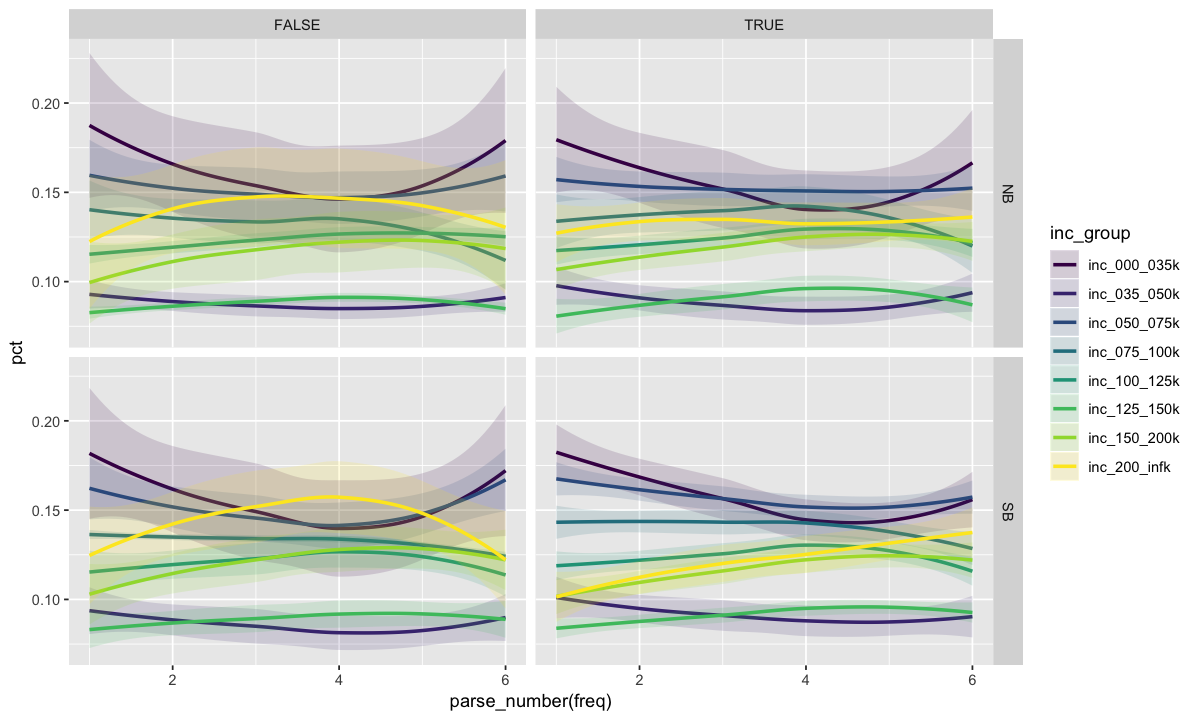

In [709]:
peak_data %>%
    filter(commercial == 0) %>%
    group_by(peak, direction, freq) %>%
    summarize_at(vars(contains("inc")), mean, na.rm=T) %>%
    select(-med_inc) %>%
    gather(inc_group, pct, -freq, -peak, -direction) %>%
ggplot(aes(parse_number(freq), pct, fill=inc_group, color=inc_group)) + 
    facet_grid(direction ~ peak) +
    #geom_col() +
    geom_smooth(method="loess", span=1, alpha=0.15) +
    scale_color_viridis_d() + 
    scale_fill_viridis_d()

## How does trip volume and the share of HOV users vary by route?

In [341]:
route_vols = trips %>%
    mutate(is_hov=coalesce(is_hov, toll==0)) %>%
    group_by(entry_plaza, exit_plaza, is_hov) %>%
    summarize(volume=n()) %>%
    arrange(entry_plaza, exit_plaza, is_hov) %>%
    execute

In [373]:
plaza_dist = read_csv("../../data/milepost_lookups/plaza_dist.csv", col_types="cid")

In [623]:
mp_annotations = tribble(
    ~direction, ~mp, ~plaza, ~label,
    "NB", 0, 1, "Bellevue",
    "NB", 2.9, 3.1, "NE 70th",
    "NB", 5, 4, "NE 116th",
    "NB", 6.7, 6, "NE 128th DAR",
    "NB", 9.5, 7.3, "SR 522",
    "NB", 12.5, 8.2, "SR 527",
    "NB", 15.4, 10, "I-5",
    "SB", 0, 1, "I-5",
    "SB", 2, 2.4, "SR 527",
    "SB", 4.5, 3.5, "SR 522",
    "SB", 7.8, 7, "NE 128th DAR",
    "SB", 9.5, 7.8, "NE 85th",
    "SB", 13, 9.5, "SR 520",
    "SB", 14.9, 10, "Bellevue",
)

ann_nb = filter(mp_annotations, direction=="NB")
ann_sb = filter(mp_annotations, direction=="SB")

In [665]:
vol_hov = route_vols %>%
    mutate(direction = if_else(entry_plaza <= 12, "NB", "SB"),
           entry_plaza = if_else(direction=="NB", entry_plaza-2, entry_plaza-12),
           exit_plaza = if_else(direction=="NB", exit_plaza-2, exit_plaza-12),
           id = str_glue("{entry_plaza}_{exit_plaza}")) %>%
    left_join(plaza_dist, by=c("direction", "entry_plaza"="plaza")) %>%
    rename(entry_mp=dist_origin) %>%
    left_join(plaza_dist, by=c("direction", "exit_plaza"="plaza")) %>%
    rename(exit_mp=dist_origin) %>%
    mutate(trip_dist = exit_mp - entry_mp) %>%
    group_by(entry_plaza, exit_plaza, direction) %>%
    mutate(pct_hov = volume/sum(volume),
           volume = sum(volume)) %>%
    ungroup %>%
    filter(is_hov==0, entry_plaza != exit_plaza)
head(vol_hov)
vol_hov %>% group_by(direction) %>% summarize(n())

entry_plaza,exit_plaza,is_hov,volume,direction,id,entry_mp,exit_mp,trip_dist,pct_hov
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<glue>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,0,502052,NB,1_3,0,2.9,2.9,0.6739840
1,4,0,662877,NB,1_4,0,6.0,6.0,0.6597061
1,5,0,225994,NB,1_5,0,6.7,6.7,0.6108525
1,7,0,229669,NB,1_7,0,8.3,8.3,0.6354493
1,8,0,120356,NB,1_8,0,12.1,12.1,0.7304912
1,9,0,19480,NB,1_9,0,14.3,14.3,0.8231520


direction,n()
<chr>,<int>
NB,35
SB,44


We can make facility schematics, plotting each trip as a line segment from their starting milepost to their ending milepost.  Then we can color the segments according to the fraction of users which are HOV, and adjust their width to reflect overall volume.  The results for the NB and SB trips are below.  Trips are sorted in order of increasing volume from left to right.

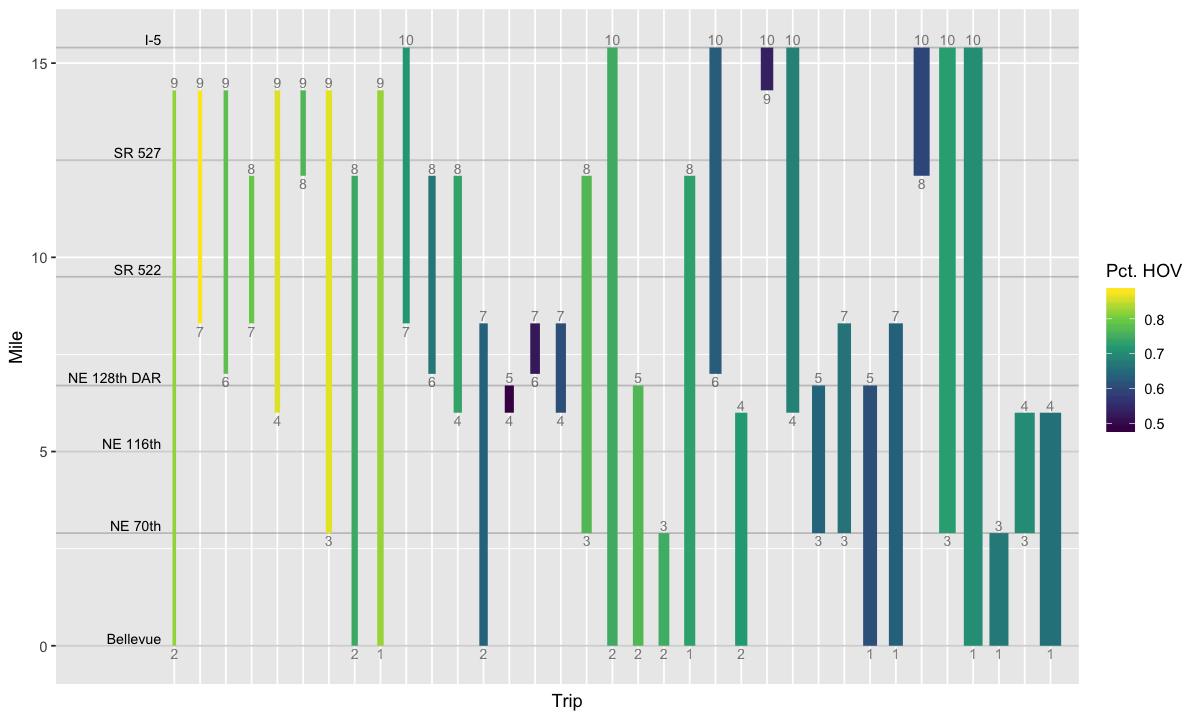

In [609]:
filter(vol_hov, direction=="NB") %>%
ggplot(aes(reorder(id, volume), ymin=entry_mp, ymax=exit_mp, size=volume, color=pct_hov)) + 
    geom_hline(aes(yintercept=mp), lty="solid", alpha=0.2, data=ann_nb) +
    geom_linerange() + 
    geom_text(aes(x=0.5, y=mp, label=label), size=3, hjust="right", nudge_y=0.2, data=ann_nb, inherit.aes=F) +
    geom_text(aes(label=exit_plaza, y=exit_mp), size=3, color="black", alpha=0.5, nudge_y=0.2) + 
    geom_text(aes(label=entry_plaza, y=entry_mp), size=3, color="black", alpha=0.5, nudge_y=-0.2) + 
    #theme(axis.text.x=element_text(angle=90)) + 
    coord_cartesian(xlim=c(-3, 35.5)) + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + 
    guides(size=F) + 
    labs(x="Trip", y="Mile", color="Pct. HOV")

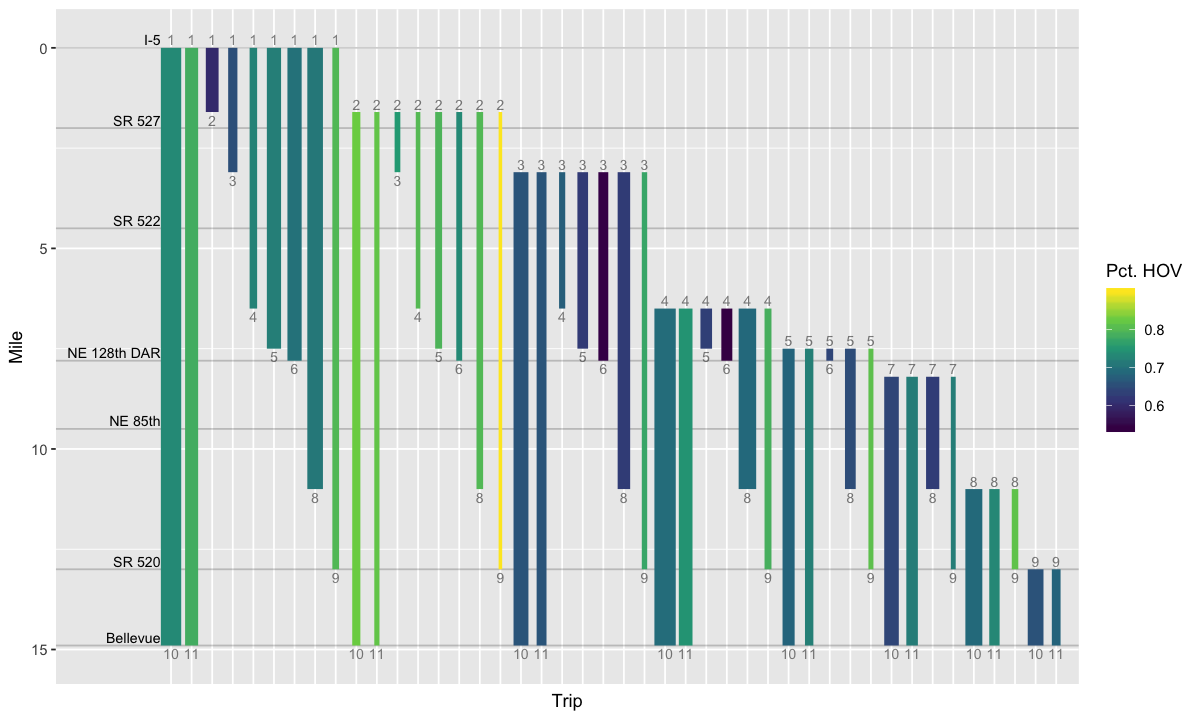

In [608]:
filter(vol_hov, direction=="SB") %>%
ggplot(aes(reorder(id, entry_plaza), ymin=entry_mp, ymax=exit_mp, size=volume, color=pct_hov)) + 
    geom_hline(aes(yintercept=mp), lty="solid", alpha=0.2, data=ann_sb) +
    geom_linerange() + 
    geom_text(aes(x=0.5, y=mp, label=label), size=3, hjust="right", nudge_y=0.2, data=ann_sb, inherit.aes=F) +
    geom_text(aes(label=exit_plaza, y=exit_mp), size=3, color="black", alpha=0.5, nudge_y=-0.2) + 
    geom_text(aes(label=entry_plaza, y=entry_mp), size=3, color="black", alpha=0.5, nudge_y=+0.2) + 
    #theme(axis.text.x=element_text(angle=90)) + 
    coord_cartesian(xlim=c(-4, 44.5)) + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + 
    guides(size=F) + 
    scale_y_reverse() +
    labs(x="Trip", y="Mile", color="Pct. HOV")

We notice that there is a correlation between volume and HOV usage—higher-volume trips have lower relative HOV usage.  This makes sense, as trip volume is correlated with congestion, which gives SOV drivers an incentive to buy into the HOT lanes.  This can be confirmed with a scatterplot of volume and HOV usage.

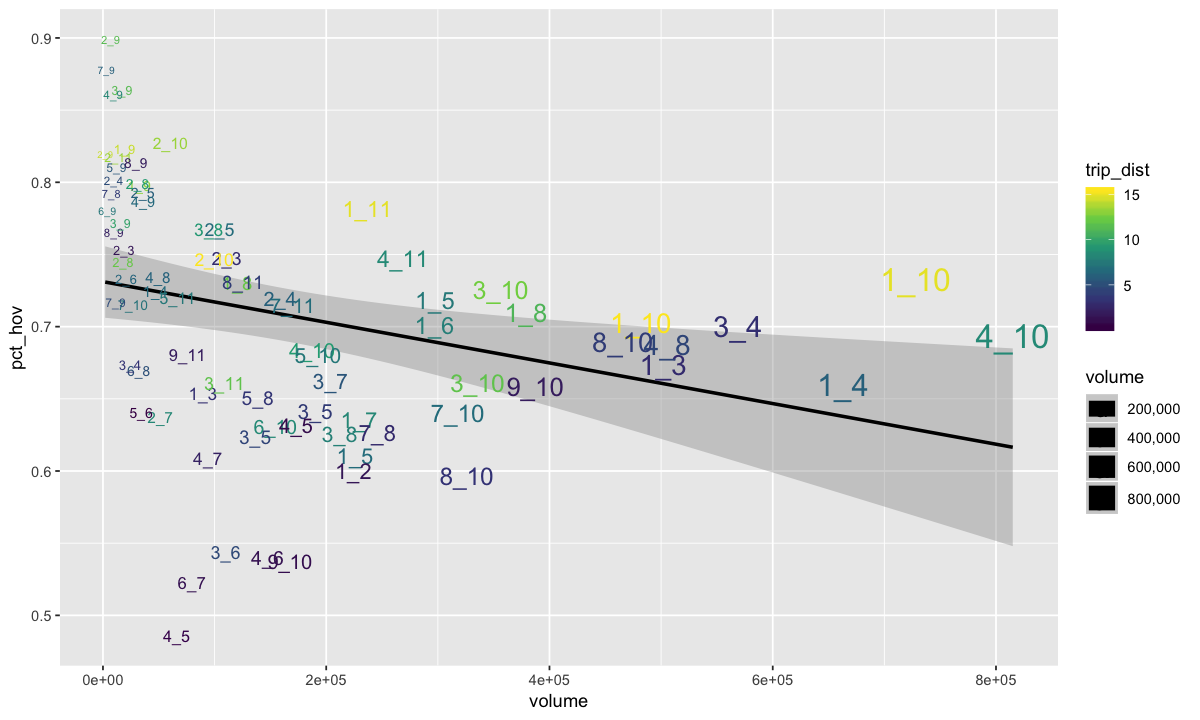

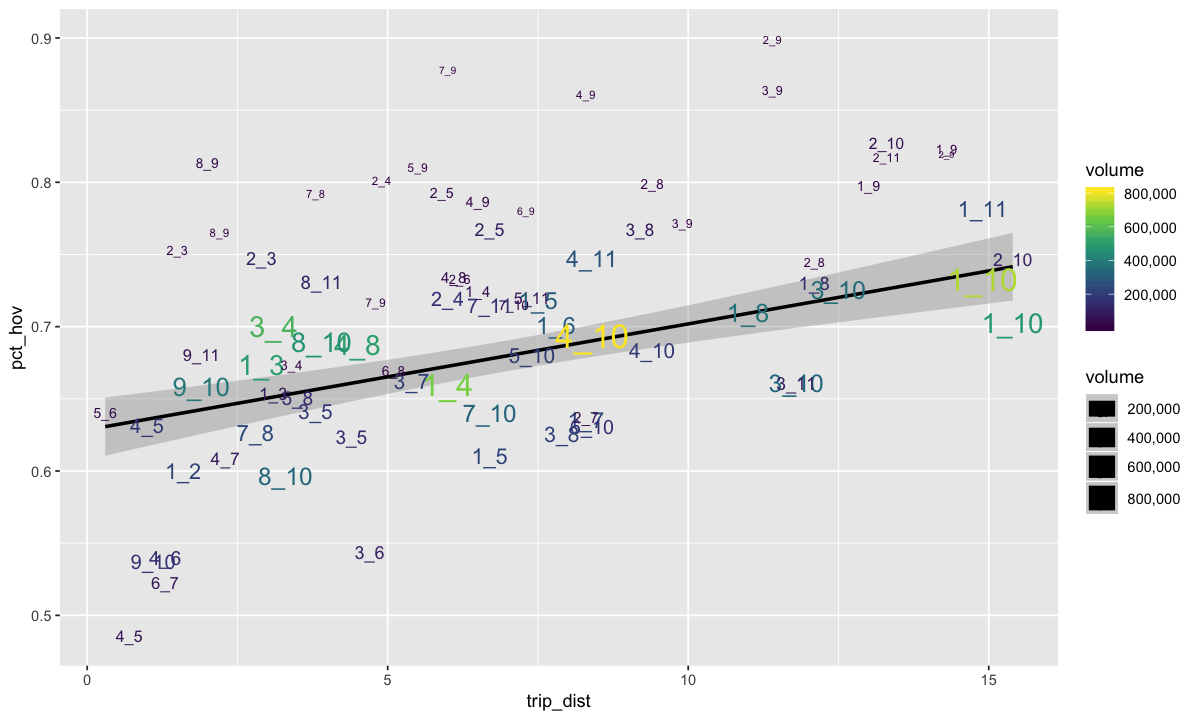

In [674]:
ggplot(vol_hov, aes(volume, pct_hov, color=trip_dist, size=volume, label=id)) + 
    geom_smooth(method=lm, color="black") + 
    scale_size_continuous(range=c(2, 7), labels=scales::comma) +
    geom_text()
ggplot(vol_hov, aes(trip_dist, pct_hov, size=volume, color=volume, label=id)) + 
    geom_smooth(aes(weight=volume), method=lm, color="black") + 
    scale_color_viridis_c(labels=scales::comma) +
    scale_size_continuous(range=c(2, 7), labels=scales::comma) +
    geom_text()

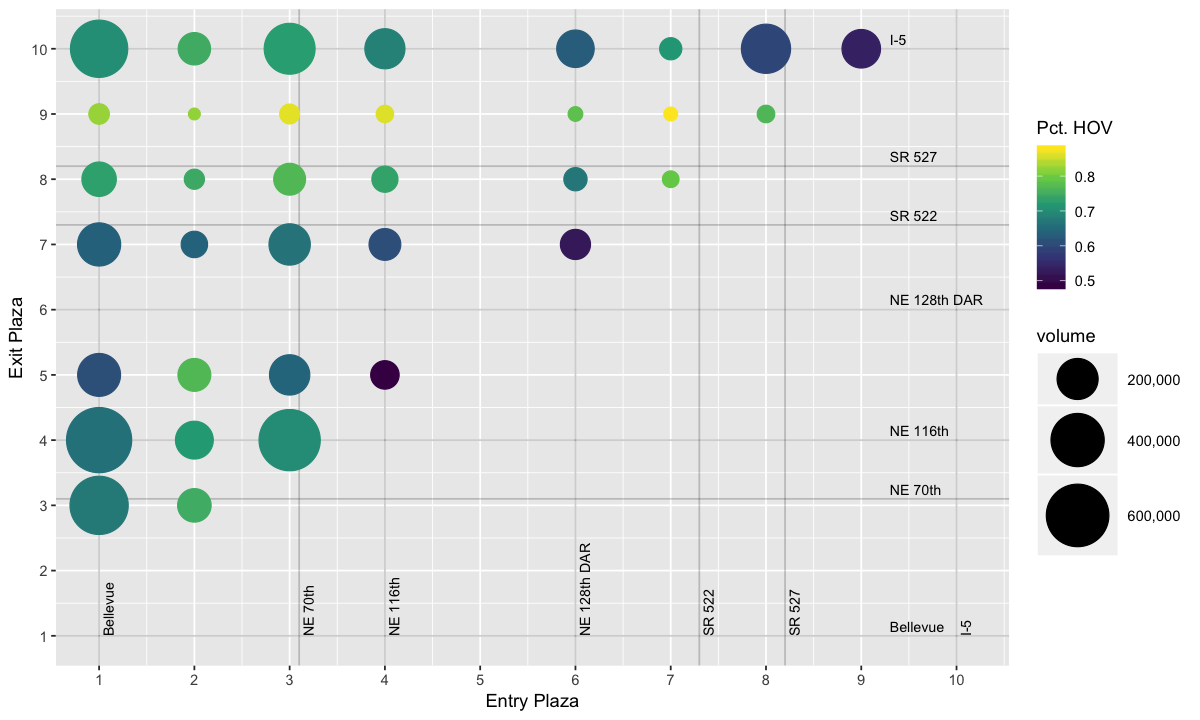

In [664]:
filter(vol_hov, direction=="NB") %>%
ggplot(aes(x=entry_plaza, y=exit_plaza, size=volume, color=pct_hov)) + 
    geom_hline(aes(yintercept=plaza), lty="solid", alpha=0.2, data=ann_nb) +
    geom_vline(aes(xintercept=plaza), lty="solid", alpha=0.2, data=ann_nb) +
    geom_point() +
    geom_text(aes(x=9.3, y=plaza, label=label), size=3, hjust="left", nudge_y=0.15, data=ann_nb, inherit.aes=F) +
    geom_text(aes(y=1.0, x=plaza, label=label), size=3, hjust="left", nudge_x=+0.1, angle=90, data=ann_nb, inherit.aes=F) +
    scale_x_continuous(breaks=1:10) + 
    scale_y_continuous(breaks=1:10) + 
    scale_size_continuous(range=c(3, 18), labels=scales::comma) +
    labs(x="Entry Plaza", y="Exit Plaza", color="Pct. HOV")

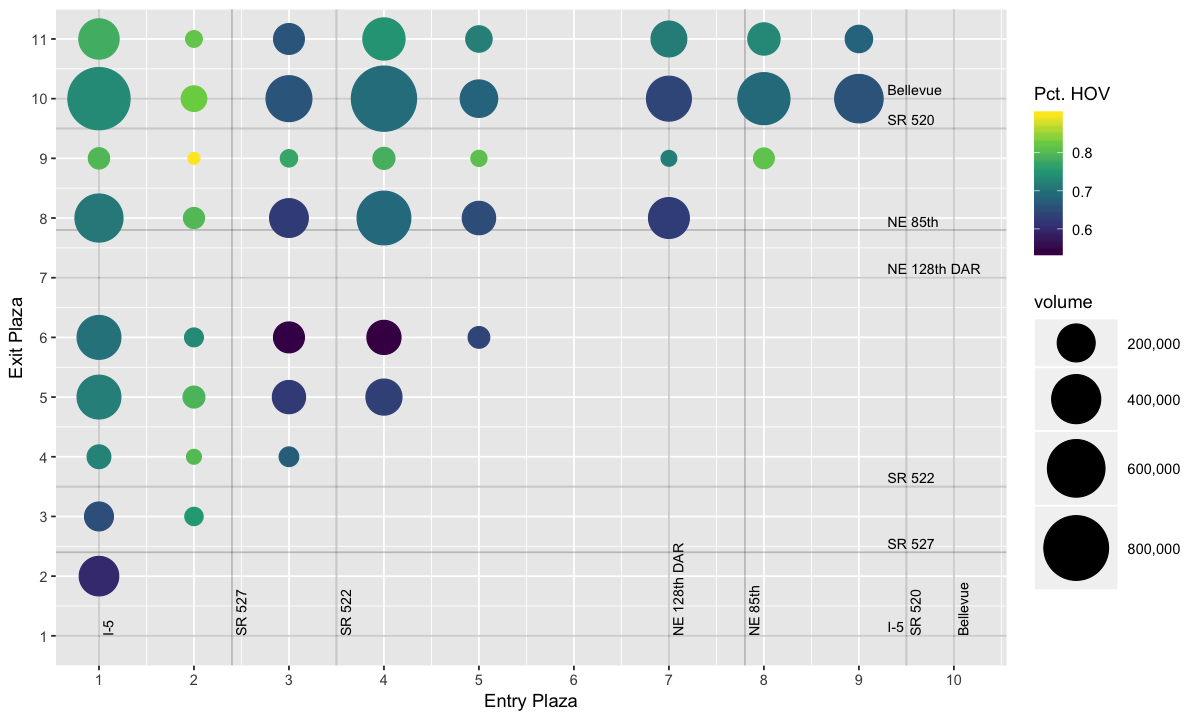

In [761]:
filter(vol_hov, direction=="SB") %>%
ggplot(aes(x=entry_plaza, y=exit_plaza, size=volume, color=pct_hov)) + 
    geom_hline(aes(yintercept=plaza), lty="solid", alpha=0.2, data=ann_sb) +
    geom_vline(aes(xintercept=plaza), lty="solid", alpha=0.2, data=ann_sb) +
    geom_point() +
    geom_text(aes(x=9.3, y=plaza, label=label), size=3, hjust="left", nudge_y=0.15, data=ann_sb, inherit.aes=F) +
    geom_text(aes(y=1.0, x=plaza, label=label), size=3, hjust="left", nudge_x=+0.1, angle=90, data=ann_sb, inherit.aes=F) +
    scale_x_continuous(breaks=1:11) + 
    scale_y_continuous(breaks=1:11) + 
    scale_size_continuous(range=c(3, 18), labels=scales::comma) +
    labs(x="Entry Plaza", y="Exit Plaza", color="Pct. HOV")